## Solution of the home assignment for Emplifi

### Javad M.Rad
### javad_mohamadi_rad@yahoo.com
### +420 721024504

# 1. Environment Setup and loading libraries

In [1]:
import json
import os
import numpy as np
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering

from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.neighbors import NearestNeighbors

from wordcloud import WordCloud
import matplotlib.pyplot as plt

c:\Users\Javad\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Data Loading and Preprocessing

In [2]:
# Load data
current_folder = os.getcwd()  # Get the current working directory
assignment_folder = os.path.join(current_folder, "assignment")  # Navigate to the 'assignment' subfolder
input_json_path = os.path.join(assignment_folder, "posts_with_topics.json")  # Full path to the JSON file
with open(input_json_path, 'r', encoding='utf-8') as f:
    posts = json.load(f)

# Collect all unique topics
all_topics = set()
for post in posts:
    for t in post["topics"]:
        all_topics.add(t)

all_topics = list(all_topics)
topic_index = {topic: i for i, topic in enumerate(all_topics)}
num_topics = len(all_topics)

print('Number of unique topics: ', num_topics)

Number of unique topics:  110


# 3. Creating Sparse Co-occurrence Matrix, Dimensionality Reduction with PCA and UMAP
A common way to measure how closely topics are related is to compute Co-occurrence Matrix that is, how often they appear together.

In [3]:
# Create a sparse co-occurrence matrix
data, row, col = [], [], []
for post in posts:
    ts = post["topics"]
    indices = [topic_index[t] for t in ts]
    for i in range(len(indices)):
        for j in range(i + 1, len(indices)):
            row.append(indices[i])
            col.append(indices[j])
            data.append(1)

co_matrix_sparse = coo_matrix((data, (row, col)), shape=(num_topics, num_topics))
co_matrix_sparse = co_matrix_sparse + co_matrix_sparse.T

# Calculate topic frequency
topic_frequency = np.array(co_matrix_sparse.sum(axis=1)).flatten()


# Dimensionality Reduction with PCA
co_matrix_dense = co_matrix_sparse.toarray()
pca = PCA(random_state=42, n_components=0.99) # Least amount of variance to meet
reduced_matrix = pca.fit_transform(co_matrix_dense)


# Dimensionality Reduction with UMAP
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=50, random_state=42)
umap_embedding = umap.fit_transform(co_matrix_dense)

# Quick checks
print("Co-occurrence sparse matrix shape:", co_matrix_sparse.shape)
# print("Example row (first topic):", co_matrix_sparse[0, :])

print("\nCo-occurrence matrix shape with PCA dimensionality reduction:", reduced_matrix.shape)
print("Selected components with PCA:", pca.components_.tolist())
# print("Example row (first topic):", reduced_matrix[0, :])

print("\nCo-occurrence matrix shape with UMAP dimensionality reduction:", umap_embedding.shape)
print("Selected components with UMAP:", umap_embedding.tolist())
# print("Example row (first topic):", umap_embedding[0, :])

c:\Users\Javad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Javad\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Co-occurrence sparse matrix shape: (110, 110)

Co-occurrence matrix shape with PCA dimensionality reduction: (110, 61)
Selected components with PCA: [[0.0351424989892263, -0.003435882591463657, 0.13208335852817465, -0.015863016440057567, -0.006650251915648248, 0.0011093832324717934, 0.10133173386288064, 0.022009768803692643, 0.25216304330058964, 0.03765259416965278, 0.16800865895833073, 0.007880293804817327, -0.0003412769573614481, 0.033857233894949816, -0.01812468283245261, -0.01253941056294749, -0.017701532729179188, 0.005237248395507497, 0.006793981240267084, 0.0011535144750615027, 0.000743374959824155, 0.014944610783804789, 0.017184358303789973, 0.1399486807957003, 0.007186110135162393, 0.19492389579997546, 0.041923960920989954, 0.04424383713475791, -0.005710814400212861, -0.014038741772521537, 0.019982313104948364, 0.0011535144750615025, -0.012841771560142897, 0.007898373053924634, 0.054862547311833765, 0.08406526695069966, -0.01586301644005755, -0.012900971280997077, 0.0813074223

# 4. Hierarchical Clustering
We'll define a recursive function that:
1) Clusters the given list of topic indices (topic_indices).
2) Splits them into sub-clusters if they exceed certain size / depth.
3) Returns a hierarchical tree.

In [4]:
# Hierarchical Clustering
def hierarchical_clustering(topic_indices, umap_embedding, depth=0, max_depth=3, min_cluster_size=5, n_neighbors=10):
    """
    Recursively clusters a subset of topics using hierarchical clustering with a UMAP embedding.

    Args:
        topic_indices (list[int]): A list of indices representing the topics to be clustered at the current node.
        umap_embedding (np.array): A 2D array of UMAP-embedded points, where each row corresponds to a topic.
        depth (int, optional): The current depth of recursion. Default is 0.
        max_depth (int, optional): The maximum number of recursive levels in the hierarchy. Default is 3.
        min_cluster_size (int, optional): The minimum size of a cluster to be further subdivided. Default is 5.
        n_neighbors (int, optional): The number of nearest neighbors to consider when calculating distances. Default is 10.

    Returns:
        dict: A hierarchical tree structure representing clusters and their subclusters:
            - "topics" (list[int]): Indices of topics in the current cluster.
            - "subclusters" (list[dict]): List of child cluster dictionaries with the same structure.

    What it Does:
        - Checks base conditions for recursion (e.g., maximum depth reached or cluster size too small).
        - Uses the UMAP embedding to calculate distances between points in the current cluster.
        - Applies `AgglomerativeClustering` to cluster the topics based on their distances.
        - Groups topics into subclusters and recursively calls itself for each subcluster.
        - Constructs and returns a hierarchical tree where each node contains:
            - Topics in the current cluster.
            - Recursively constructed subclusters.
    """
    if depth >= max_depth or len(topic_indices) < min_cluster_size:
        return {
            "topics": topic_indices,
            "subclusters": []
        }

    nn = NearestNeighbors(n_neighbors=min(len(topic_indices), n_neighbors))
    nn.fit(umap_embedding[topic_indices])
    distances, _ = nn.kneighbors(umap_embedding[topic_indices])

    cluster_model = AgglomerativeClustering(
        metric='euclidean',
        linkage='average',
        n_clusters=min(5, len(topic_indices))
    )
    labels = cluster_model.fit_predict(distances)

    clusters_dict = defaultdict(list)
    for i, label in enumerate(labels):
        clusters_dict[label].append(topic_indices[i])

    subclusters = []
    for _, child_topic_indices in clusters_dict.items():
        child_cluster = hierarchical_clustering(
            topic_indices=child_topic_indices,
            umap_embedding=umap_embedding,
            depth=depth + 1,
            max_depth=max_depth,
            min_cluster_size=min_cluster_size,
            n_neighbors=n_neighbors
        )
        subclusters.append(child_cluster)

    return {
        "topics": topic_indices,
        "subclusters": subclusters
    }

root_cluster = hierarchical_clustering(
    topic_indices=list(range(num_topics)),
    umap_embedding=umap_embedding,
    depth=0,
    max_depth=3,
    min_cluster_size=5,
    n_neighbors=10
)

# 5. Building a Tree Structure and Saving the Hierarchy as JSON

In [5]:
# Building a Tree Structure
def build_output_tree(cluster_node, all_topics, topic_frequency):
    """
    Transform the hierarchical clustering node into a JSON-ready structure with:
    - 'topics': a list of { "topic": str, "frequency": int }
    - 'children': a list of subclusters
    
    Args:
        cluster_node (dict): A node from hierarchical_clustering
        all_topics (list[str]): Master list of topic strings
        topic_frequency (np.array): Frequencies of each topic index

    Returns:
        dict: { "topics": [...], "children": [...] }
    """
    topic_data = []
    for idx in cluster_node["topics"]:
        topic_data.append({
            "topic": all_topics[idx],
            "frequency": int(topic_frequency[idx])
        })

    children = []
    for sub_node in cluster_node["subclusters"]:
        children.append(build_output_tree(sub_node, all_topics, topic_frequency))

    return {
        "topics": topic_data,
        "children": children
    }

hierarchy_json = build_output_tree(root_cluster, all_topics, topic_frequency)

# Save as JSON
output_json_path = 'big_data_topics_hierarchy.json'
print(f"Saving hierarchy to {output_json_path}")
with open(output_json_path, 'w', encoding='utf-8') as f:
    json.dump(hierarchy_json, f, indent=2, ensure_ascii=False)

print("Hierarchy successfully saved!")

Saving hierarchy to big_data_topics_hierarchy.json
Hierarchy successfully saved!


# 6. Visualization with Word Cloud

Displaying Word Cloud for All Topics


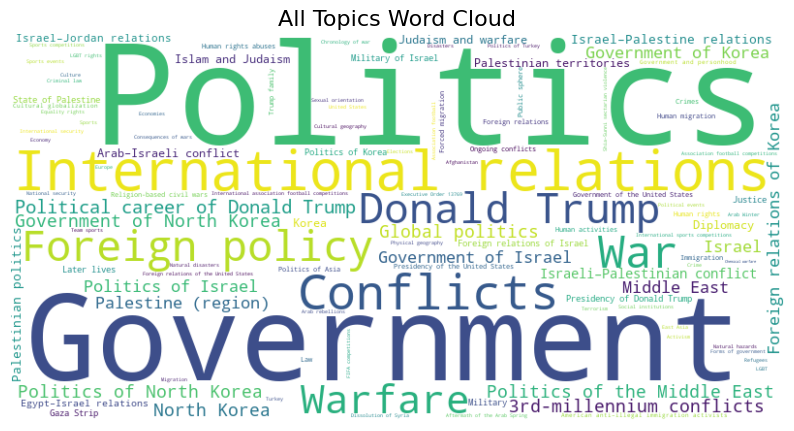

Displaying Word Clouds for Clusters


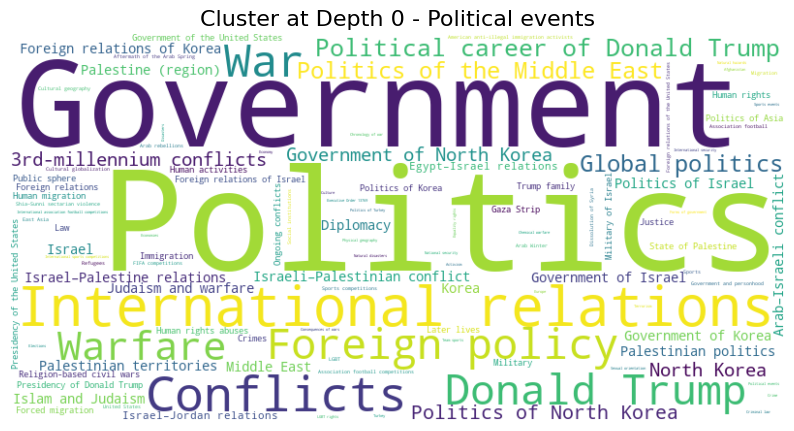

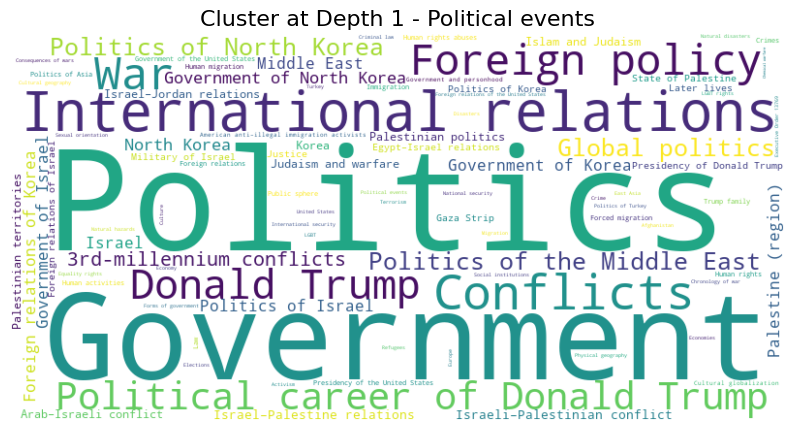

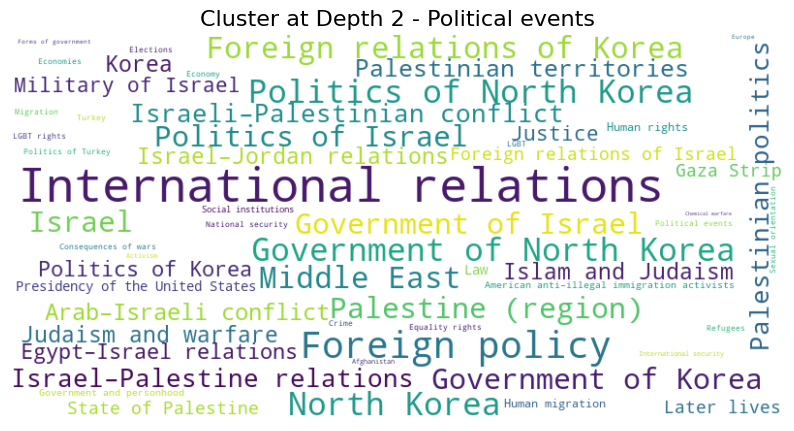

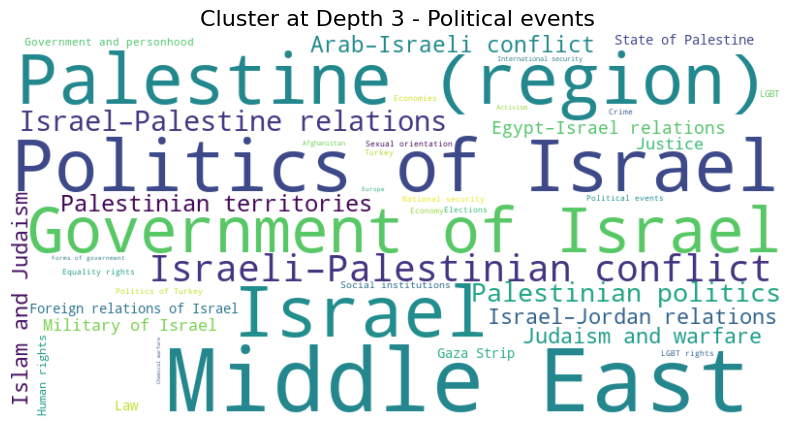

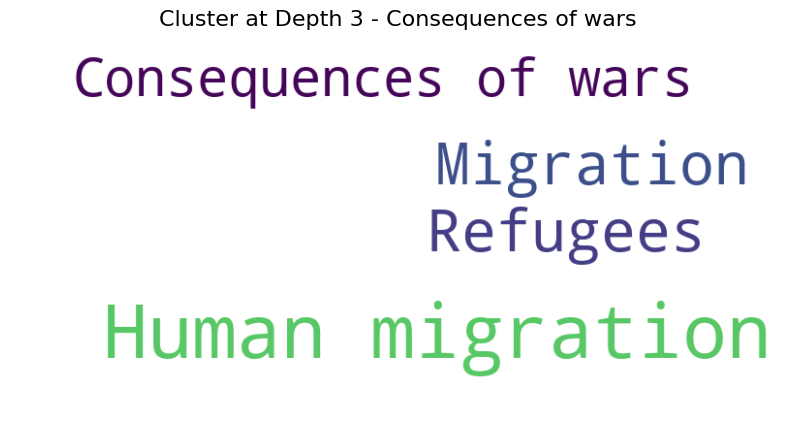

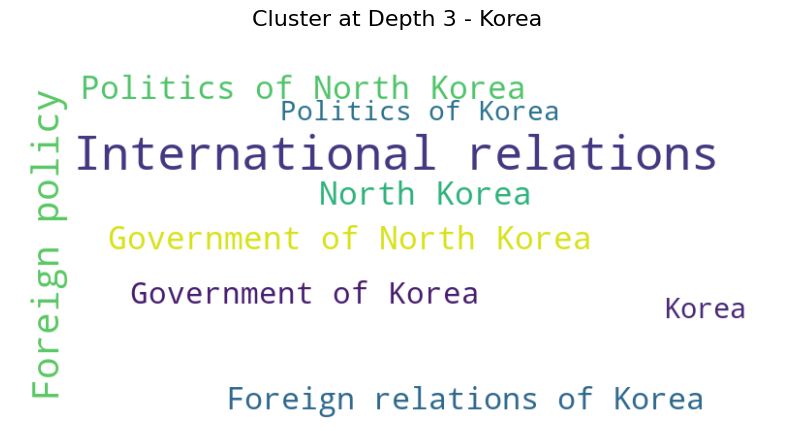

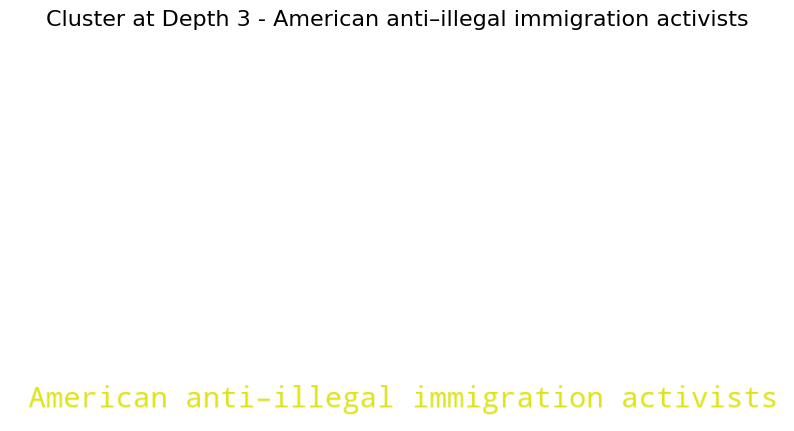

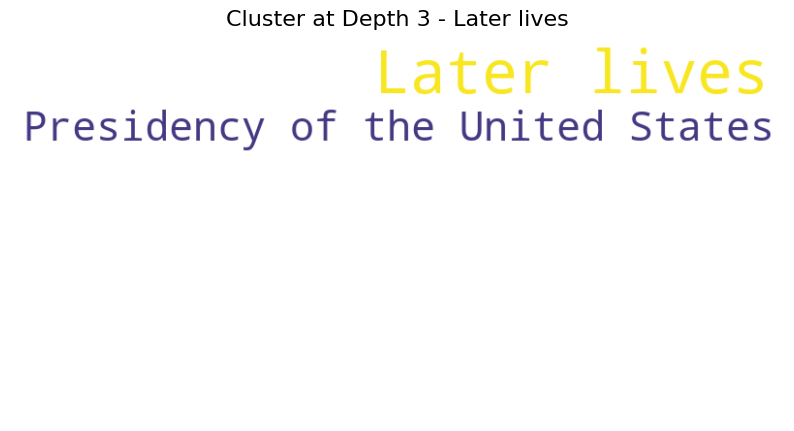

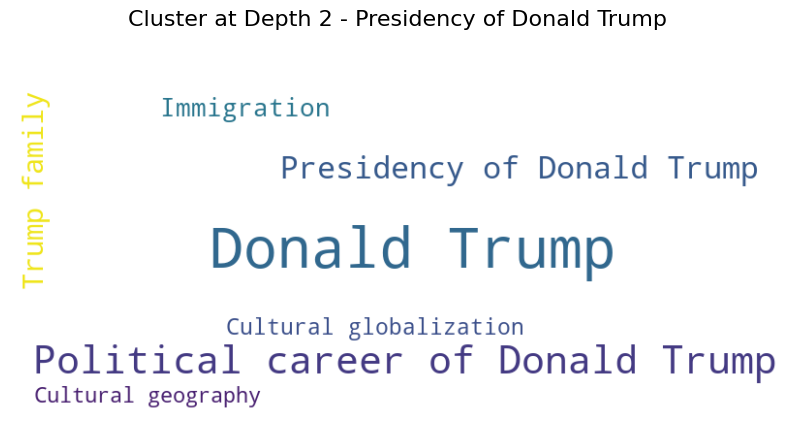

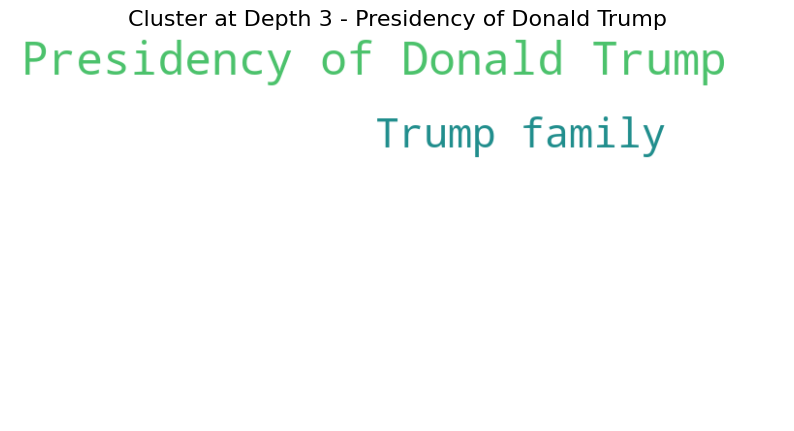

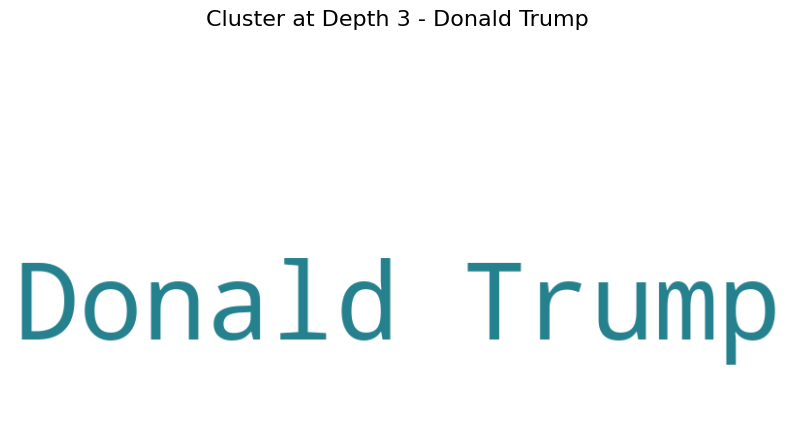

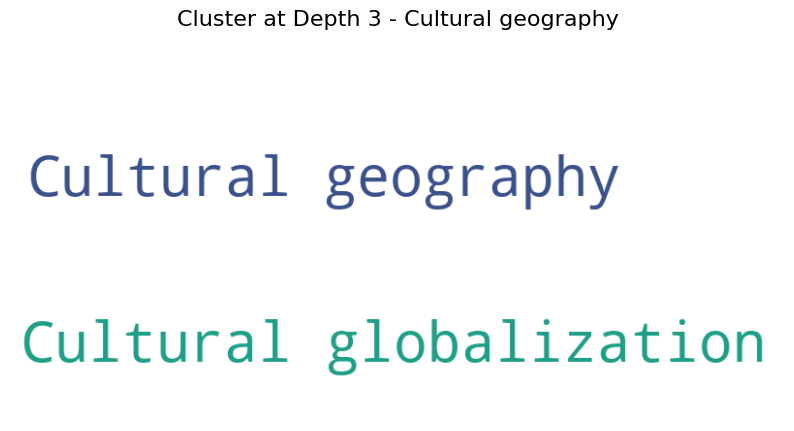

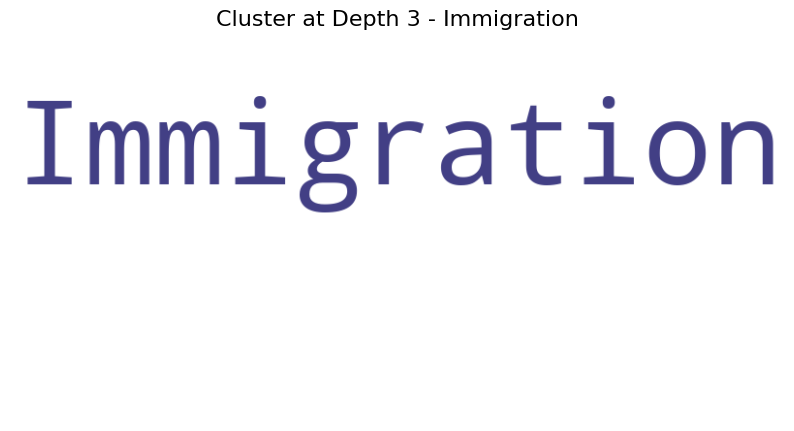

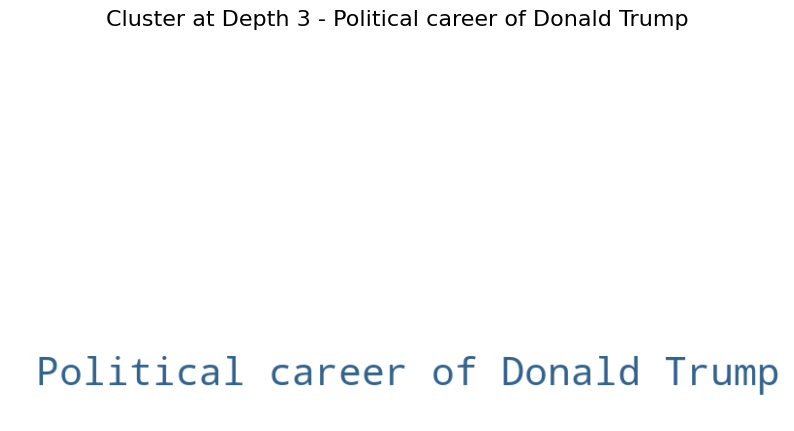

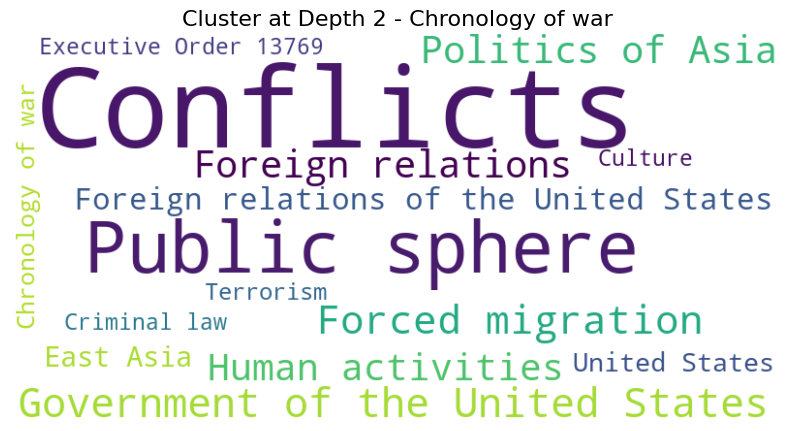

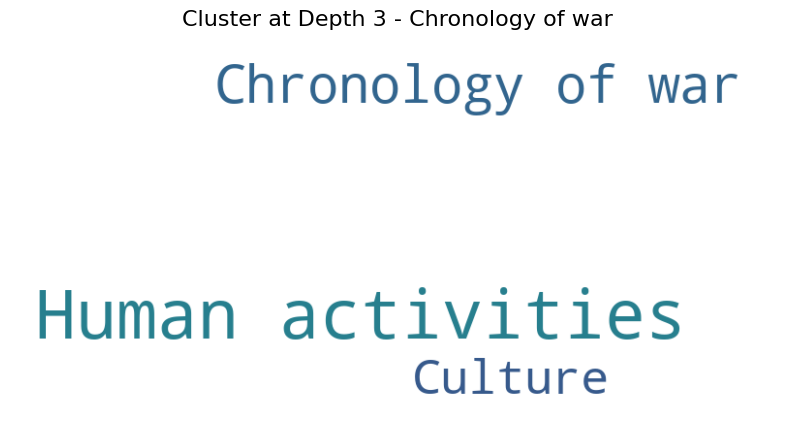

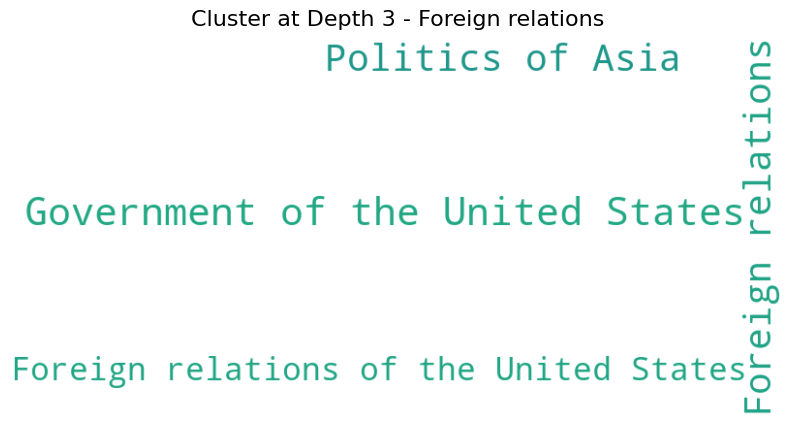

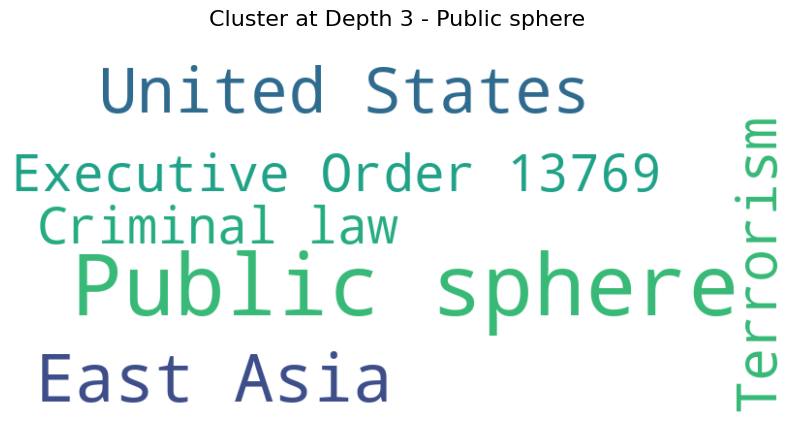

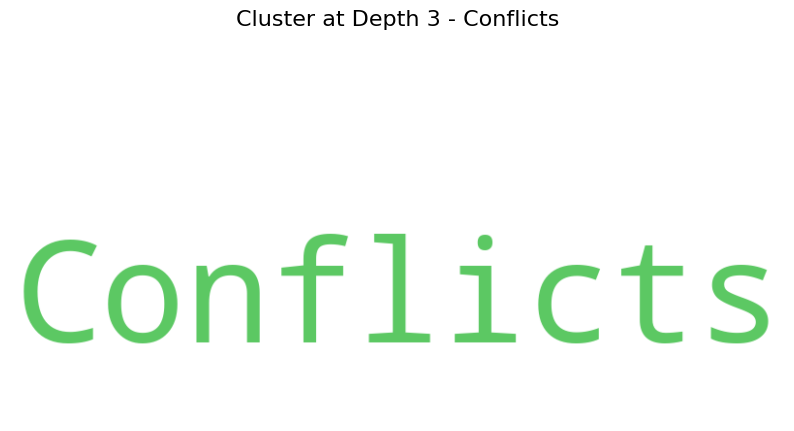

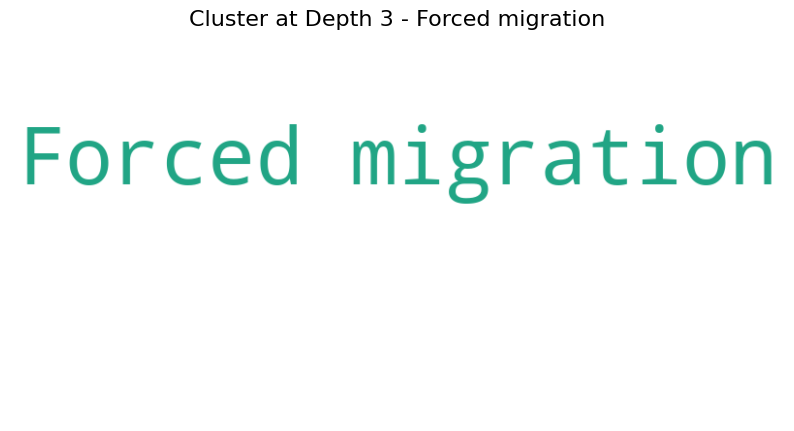

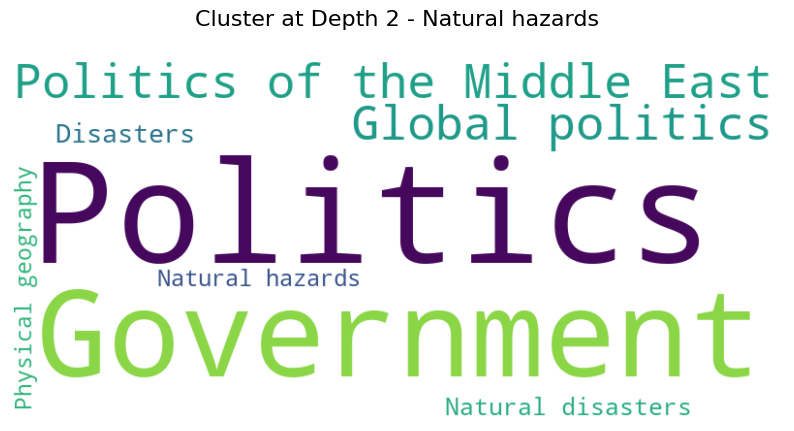

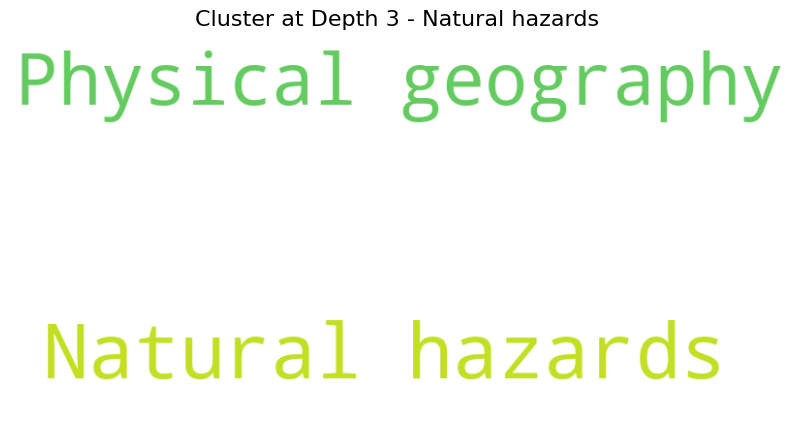

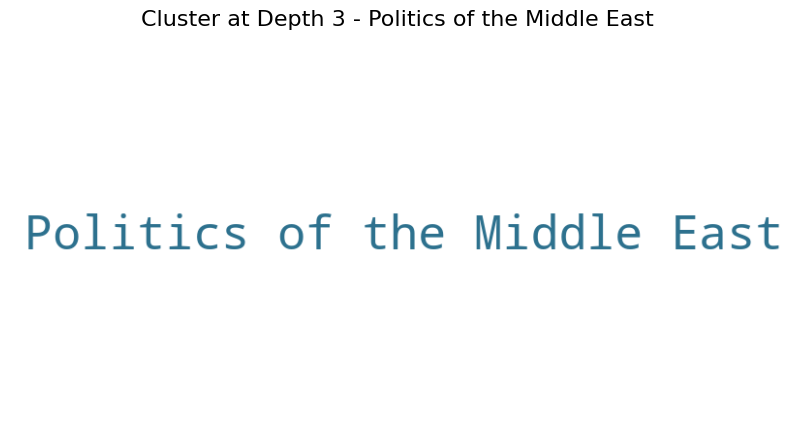

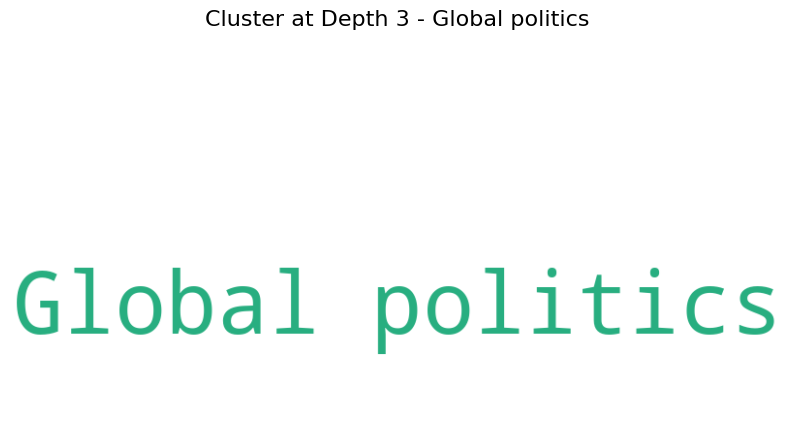

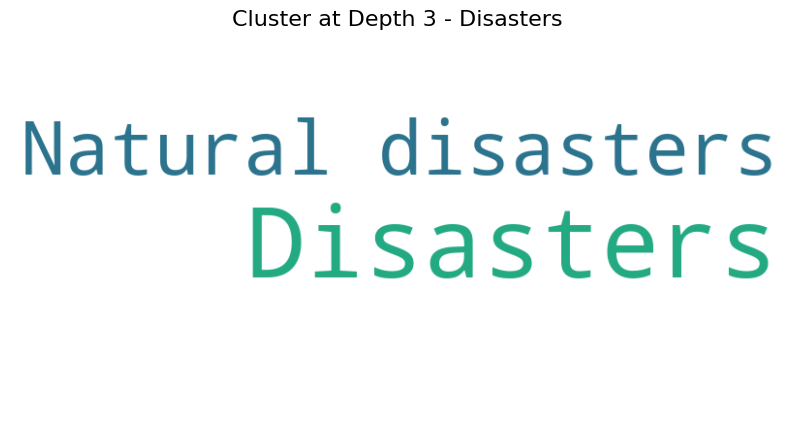

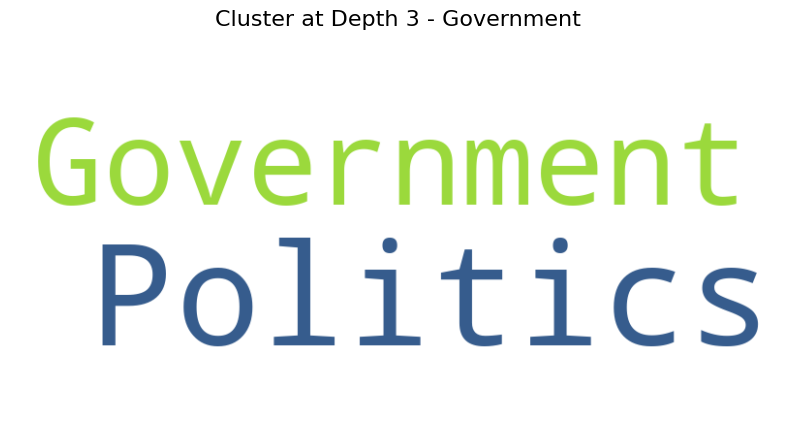

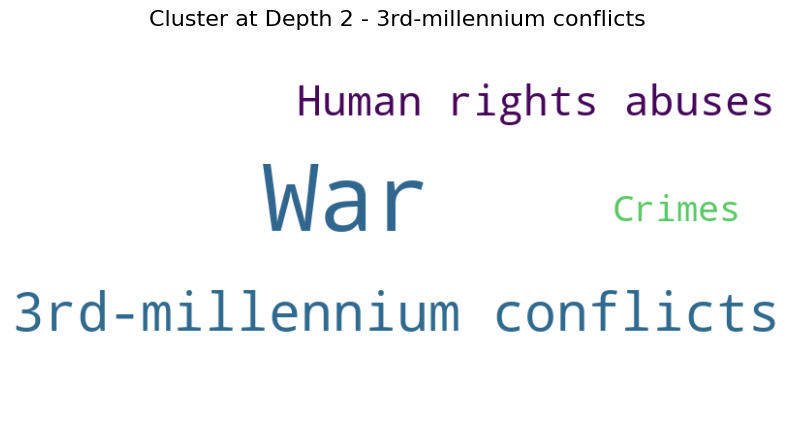

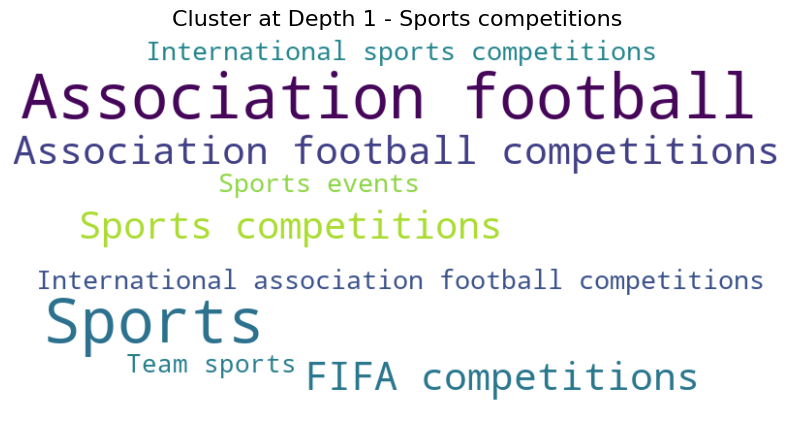

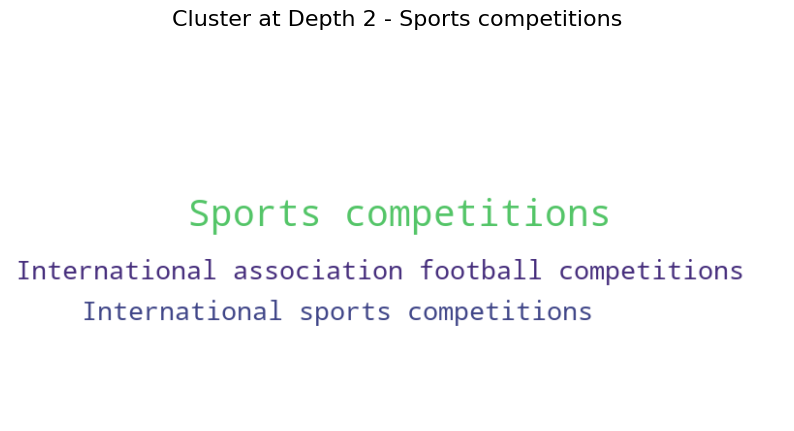

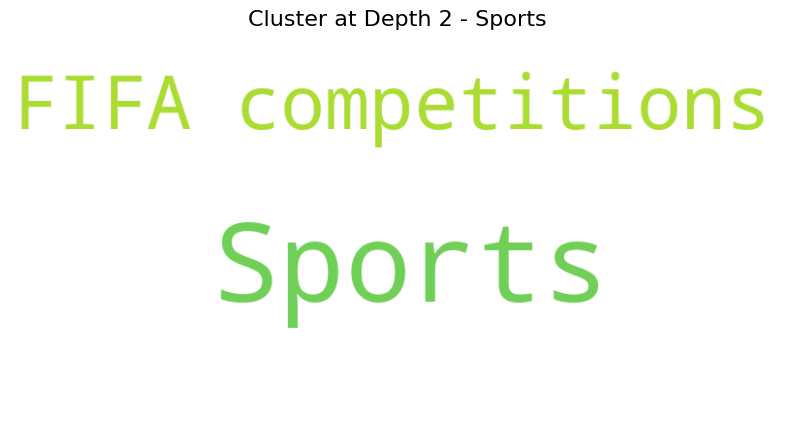

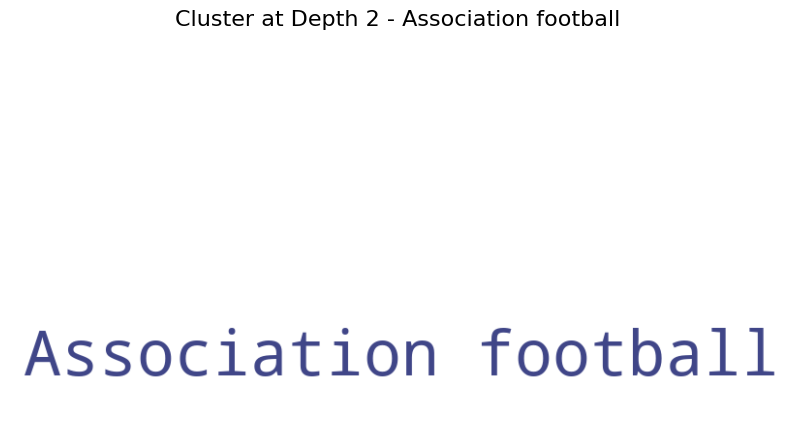

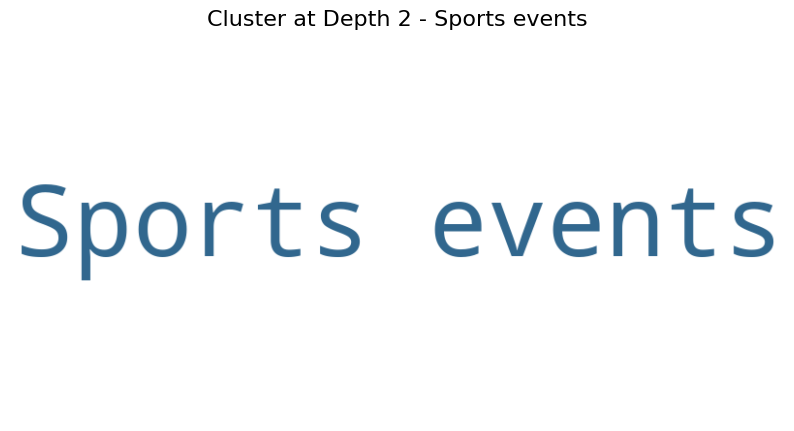

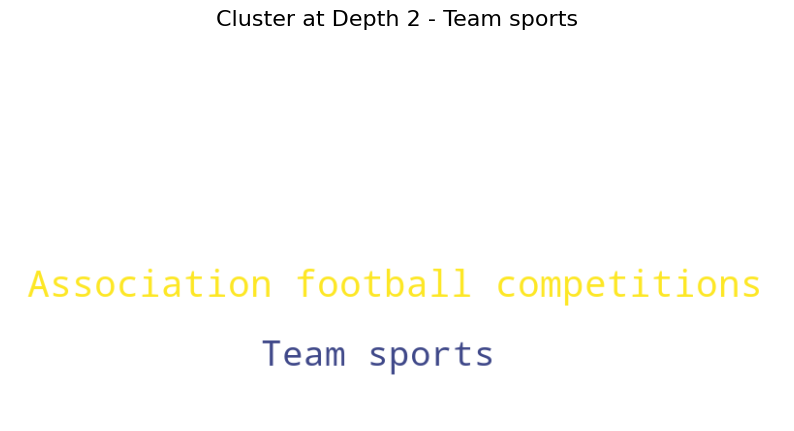

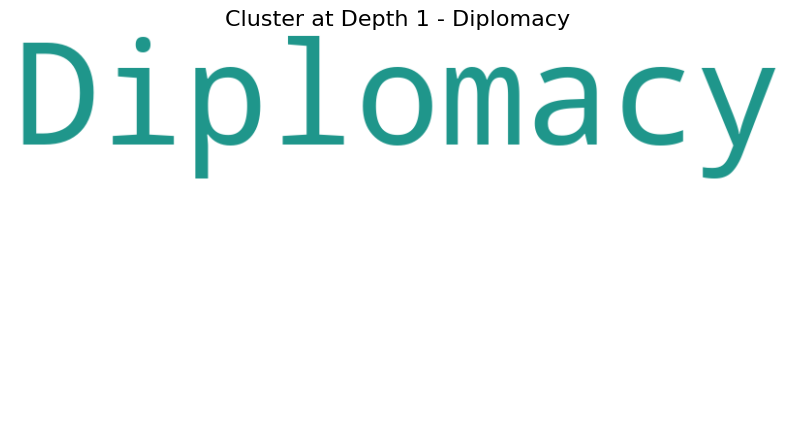

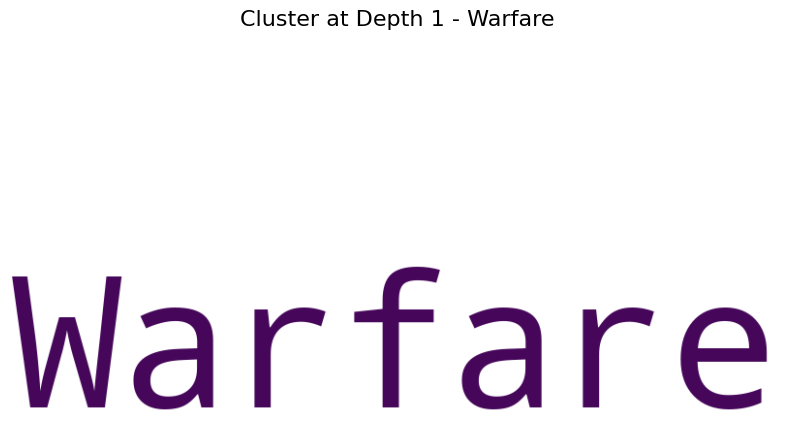

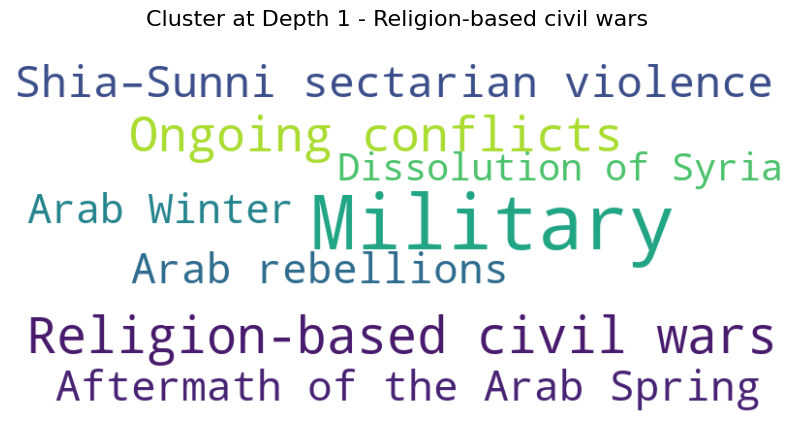

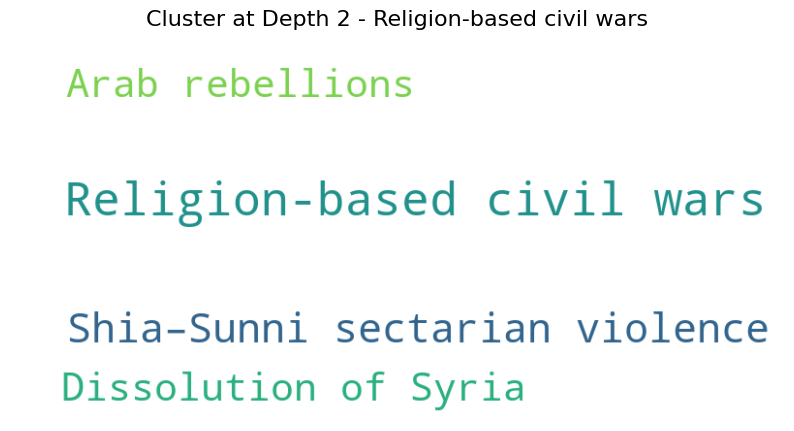

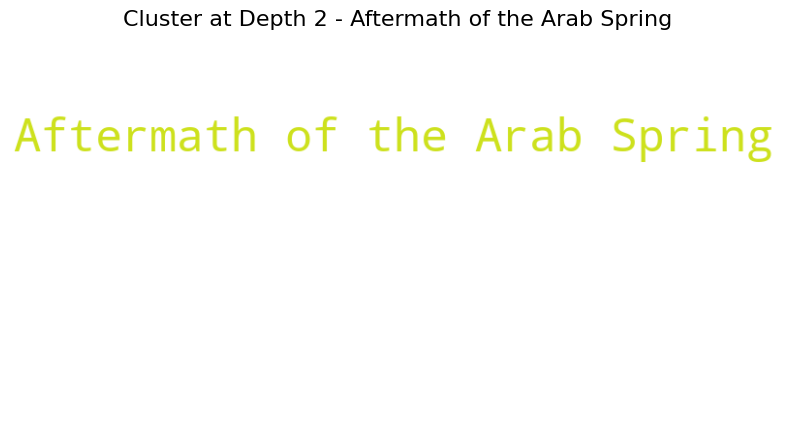

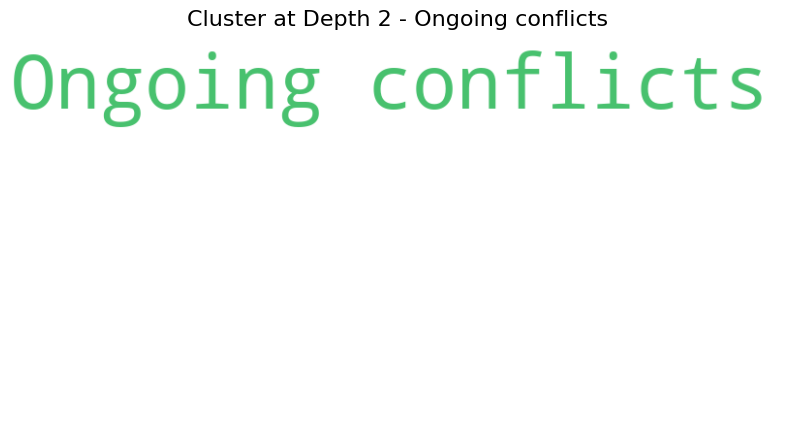

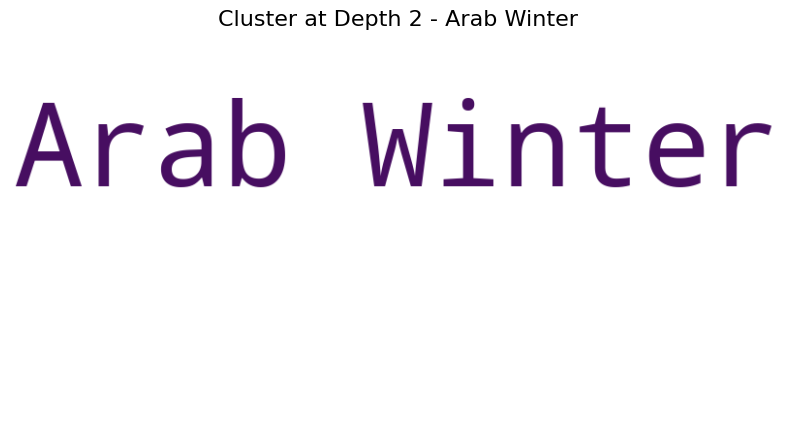

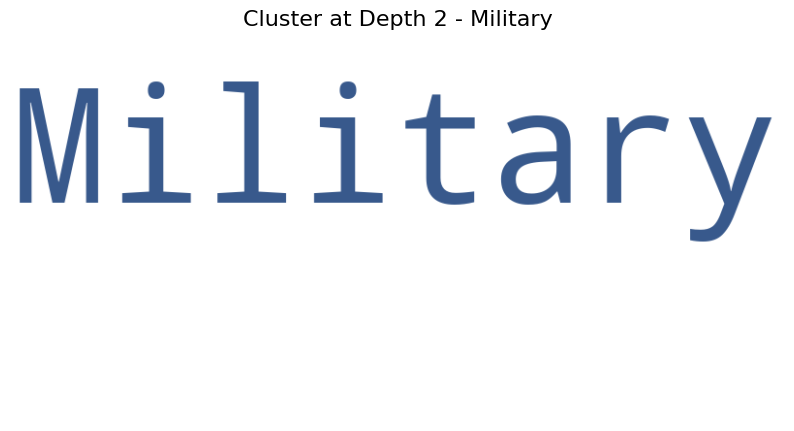

In [6]:
# Visualization - Word Cloud
def generate_word_cloud(topic_data, title=None):
    """
    Generate a word cloud visualization from a list of topics and their frequencies.

    Args:
        topic_data (list[dict]): A list of dictionaries, where each dictionary represents a topic and its frequency.
                                 Example: [{"topic": "Politics", "frequency": 20}, {"topic": "Economy", "frequency": 15}]
        title (str, optional): The title of the word cloud visualization. Default is None.

    What it Does:
        - Converts the input `topic_data` into a dictionary of frequencies.
        - Uses the WordCloud library to generate a word cloud from these frequencies.
        - Displays the word cloud using Matplotlib.
        - If a title is provided, it adds the title above the word cloud.

    Returns:
        None: Displays the word cloud plot.
    """
    frequencies = {topic["topic"]: topic["frequency"] for topic in topic_data}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=16)
    plt.show()

def display_cluster_wordcloud(cluster_node, all_topics, topic_frequency, depth=0):
    """
    Recursively generate word clouds for clusters in a hierarchical structure.

    Args:
        cluster_node (dict): A dictionary representing a node in the cluster hierarchy.
                             Contains:
                             - "topics": List of topic indices in the current cluster.
                             - "subclusters": List of child cluster dictionaries (each in the same format).
        all_topics (list[str]): A list of all topic names, where the index corresponds to the topic ID.
                                Example: ["Politics", "Economy", "Science"]
        topic_frequency (np.array): An array of frequencies for each topic, where index matches the topic ID.
                                    Example: [20, 15, 10]
        depth (int, optional): The depth of the current cluster in the hierarchy. Default is 0.

    What it Does:
        - Extracts the topics and their frequencies for the current cluster using the indices in `cluster_node["topics"]`.
        - Generates a word cloud for the current cluster with a title that indicates its depth.
        - Recursively calls itself for each subcluster in `cluster_node["subclusters"]` to generate word clouds for deeper levels.

    Returns:
        None: Displays the word cloud plots for the current cluster and all its subclusters.
    """
    # Get the topics for the current cluster
    topic_data = [
        {"topic": all_topics[idx], "frequency": int(topic_frequency[idx])}
        for idx in cluster_node["topics"]
    ]
    
    # Generate title based on the depth and primary topic (if available)
    if topic_data:
        title = f"Cluster at Depth {depth} - {topic_data[0]['topic']}"
    else:
        title = f"Cluster at Depth {depth}"

    # Generate word cloud for the current cluster
    generate_word_cloud(topic_data, title=title)

    # Recursively generate word clouds for subclusters
    for sub_node in cluster_node["subclusters"]:
        display_cluster_wordcloud(sub_node, all_topics, topic_frequency, depth=depth + 1)

# Initial Word Cloud for All Topics
print("Displaying Word Cloud for All Topics")
generate_word_cloud(
    [{"topic": all_topics[i], "frequency": topic_frequency[i]} for i in range(num_topics)], 
    title="All Topics Word Cloud"
)

# Recursive Word Clouds for Clusters
print("Displaying Word Clouds for Clusters")
display_cluster_wordcloud(root_cluster, all_topics, topic_frequency)